In [1]:
import os
os.chdir("/mnt/iusers01/jw01/mdefscs4/ra_challenge/hestia/Hestia_imeche_vision_challenge/NN_recognition_train")

In [3]:
import tensorflow as tf
import tensorflow.keras as k
import os
import pandas as pd
import numpy as np
import random

from dataset.secondary_generator import retrieve_tf_dataset_secondary, secondary_generator

IMAGE_SIZE = 224

In [66]:
def _inverted_res_block(inputs, filters, expansion, stride, add = True):
    x = inputs
    # expand
    x = tf.keras.layers.Conv2D(filters * expansion, kernel_size=1, padding='same', activation=None, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU(6.)(x)
    # depthwise conv
    x = tf.keras.layers.DepthwiseConv2D(kernel_size=3, strides = stride, padding='same', activation=None, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU(6.)(x)
    # project
    x = tf.keras.layers.Conv2D(filters, kernel_size=1, padding='same', activation=None, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if stride == 1 and add:
        x = tf.keras.layers.Add()([inputs, x])
        return x
    else:
        return x

def model_to_train(inputs):
    x = tf.keras.layers.Conv2D(32, kernel_size=3, strides = 2, padding='same', activation=None, use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU(6.)(x)
    x = _inverted_res_block(x, filters=24, expansion=3, stride=2,)
    x = _inverted_res_block(x, filters=48, expansion=6, stride=2,)
    x = _inverted_res_block(x, filters=48, expansion=6, stride=1,)
    x = _inverted_res_block(x, filters=96, expansion=6, stride=2,)
    x = _inverted_res_block(x, filters=96, expansion=6, stride=1,)
    x = tf.keras.layers.Conv2D(300, kernel_size=1, padding='same', activation=None, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU(6.)(x)
    return x

def retrieve_mobilenet_model():
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

    inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = preprocess_input(inputs)
    x = tf.keras.applications.MobileNetV2(include_top = False, weights = "imagenet", input_shape = (224,224,3))(x)
    # x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1000, activation = None, use_bias = False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU(6.)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    letter = tf.keras.layers.Dense(36, activation = "sigmoid", name = "letter")(x)
    colour = tf.keras.layers.Dense(3, name = "colour")(x)
    model = tf.keras.Model(inputs, [letter, colour])
    return model

In [59]:
tf_data = retrieve_tf_dataset_secondary()

In [67]:
model = retrieve_mobilenet_model()

In [68]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.005),
                loss={"letter":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "colour":"mse"},
                metrics={"letter":"accuracy","colour":["mae","mse"]}, loss_weights = {"letter":1,"colour":1})

In [69]:
model.summary() 

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
tf.math.truediv_15 (TFOpLambda) (None, 224, 224, 3)  0           input_26[0][0]                   
__________________________________________________________________________________________________
tf.math.subtract_15 (TFOpLambda (None, 224, 224, 3)  0           tf.math.truediv_15[0][0]         
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Functiona (None, 7, 7, 1280)   2257984     tf.math.subtract_15[0][0]        
____________________________________________________________________________________________

In [80]:
model.fit(tf_data, epochs = 100, steps_per_epoch = 100,)

Epoch 1/100
100/100 [==============================] - 37s 372ms/step - loss: 0.4242 - letter_loss: 0.3235 - colour_loss: 0.1007 - letter_accuracy: 0.8950 - colour_mae: 0.2865 - colour_mse: 0.1007
Epoch 2/100
100/100 [==============================] - 37s 369ms/step - loss: 0.4010 - letter_loss: 0.3008 - colour_loss: 0.1002 - letter_accuracy: 0.9035 - colour_mae: 0.2861 - colour_mse: 0.1002
Epoch 3/100
100/100 [==============================] - 37s 371ms/step - loss: 0.4200 - letter_loss: 0.3196 - colour_loss: 0.1004 - letter_accuracy: 0.8968 - colour_mae: 0.2868 - colour_mse: 0.1004
Epoch 4/100
100/100 [==============================] - 37s 373ms/step - loss: 0.4418 - letter_loss: 0.3411 - colour_loss: 0.1007 - letter_accuracy: 0.8921 - colour_mae: 0.2861 - colour_mse: 0.1007
Epoch 5/100
100/100 [==============================] - 37s 368ms/step - loss: 0.4411 - letter_loss: 0.3398 - colour_loss: 0.1012 - letter_accuracy: 0.8877 - colour_mae: 0.2870 - colour_mse: 0.1012
Epoch 6/100
100

In [81]:
model.evaluate(tf_data, steps = 10, )

10/10 [==============================] - 1s 130ms/step - loss: 1.7306 - letter_loss: 1.6282 - colour_loss: 0.1024 - letter_accuracy: 0.8010 - colour_mae: 0.2902 - colour_mse: 0.1024


[1.7306020259857178,
 1.6281851530075073,
 0.10241691768169403,
 0.8010416626930237,
 0.29022088646888733,
 0.10241691768169403]

In [82]:
model.save(f'weights/step2_basic_test.tf', save_format = "tf")

INFO:tensorflow:Assets written to: weights/step2_basic_test.tf/assets


In [84]:
def sanitize(coords):
    A = np.clip(coords[0],0.01,0.99)
    B = np.clip(coords[1],0.01,0.99)
    C = np.clip(coords[2],0.15,0.7)
    D = np.clip(coords[3],0.15,0.7)
    X0 = max(A - D/1, 0)
    Y0 = max(B - C/1, 0)
    X1 = min(A + D/1, 1)
    Y1 = min(B + C/1, 1)
    return X0, X1, Y0, Y1

In [86]:
X0, X1, Y0, Y1 = sanitize([0.59549224, 0.10299957, 0.11806665, 0.11000828])

In [89]:
from PIL import Image

In [94]:
img = tf.image.resize(np.expand_dims(np.array(Image.open("../tests_chenfu/vlcsnap-2021-06-05-10h32m20s903.png"))[int(Y0*1000):int(Y1*1000)+1, int(X0*1000):int(X1*1000)+1, :], 0),(224,224), method="nearest")

In [106]:
model.predict(img)

[array([[1.00765146e-10, 4.57066120e-21, 2.12431130e-24, 6.98201461e-28,
         1.22785446e-16, 4.54570003e-25, 4.94191096e-29, 9.99943495e-01,
         5.59233810e-15, 1.29452247e-20, 9.71547479e-07, 2.73752665e-27,
         9.99995470e-01, 9.78992879e-01, 2.08301582e-25, 2.99463329e-28,
         4.73913238e-24, 3.09432951e-20, 1.07786874e-22, 8.53553356e-22,
         1.07072188e-29, 1.57895773e-21, 9.36448414e-05, 8.75230216e-06,
         6.48710178e-15, 2.72390563e-13, 1.19639811e-19, 1.35293954e-24,
         3.39700531e-27, 2.42000290e-25, 1.81424981e-16, 3.32207625e-19,
         1.90610479e-22, 1.49062702e-22, 3.31836696e-18, 3.31193941e-20]],
       dtype=float32),
 array([[0.568361  , 0.4623148 , 0.35490787]], dtype=float32)]

In [107]:
np.argmax(model.predict(img)[0])

12

In [108]:
model.predict(img)[1]*255

array([[144.93205 , 117.890274,  90.50151 ]], dtype=float32)

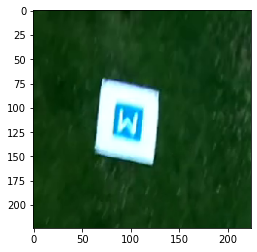

In [101]:
import matplotlib.pyplot as plt
plt.imshow(img.numpy().reshape(224,224,3))

In [103]:
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
# define a mapping of chars to integers
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))

In [105]:
int_to_char[12]

'M'